In [1]:
using Plots
e = 2.7182818284590

2.718281828459

# Optimization (tutorial)

In this tutorial you will learn to code and use common optimization algorithms for static models.


---

## Profit optimization by a monopolist

A monopolist produces quantity $q$ of goods X at price $p$. Its cost function is $c(q) = 0.5 + q (1-qe^{-q})$

The consumer's demand for price $p$ is $x(p)=2 e^{-0.5 p}$ (constant elasticity of demand to price).

__Write down the profit function of the monopolist and find the optimal production (if any). Don't use any library except for plotting.__



we have that the Firm's profit function to be :

$$ 
\Pi(p, q) = p . x(p) - c(x(p))
$$

In [2]:
cost(q::Float64) = 0.5 + q * ( 1 - q * e ^ -q)
demand(p::Float64) = 2 * e ^ (-0.5 * p)
Π(p::Float64) = p * demand(p) - cost(demand(p))

Π (generic function with 1 method)

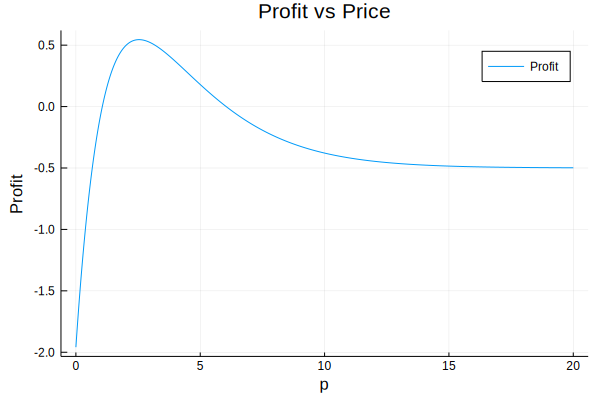

In [3]:
x = [0.01 * i for i=0:2000]
profit = Π.(x)
plot(x, profit, xlabel = "p", ylabel = "Profit", title = "Profit vs Price", label = "Profit")

We will do basic gradient descent for finding an approximation of the optimal price.

In [4]:
function Gradient_D(F::Function ; x_0 = 5.0, δ = 0.1,iters = 500, ϵ = 1e-7,  ϕ = 1e-5, λ = 0.1)
    x = x_0 - 1 # initialize
    Δ = 100
    i = 0
    steps = [x_0]
    distance = []
    while i < iters && abs(Δ) > ϵ
        x_0 = steps[i+1]
        Δ = (F(x_0) - F(x_0-δ))/δ
        x = x_0 + λ * Δ
        push!(distance, x_0 - x)
        push!(steps, x)
        i += 1
    end
    return x, steps, distance, i
end

x_min, steps, distance , i= Gradient_D(Π);

In [ ]:
anim = @animate for i ∈ 1:length(steps)
    pl = plot(x, profit, xlabel = "p", ylabel = "Profit", title = "Profit vs Price", label = "Profit")
    scatter!(pl, [steps[i]], [Π(steps[i])], xlabel= "p", ylabel = "Profit", label = "Gradient descent steps")
end
gif(anim, fps=30)

In [ ]:
println("We found that the approximate optimal price is $(x_min)")

In [ ]:
#plot(distance, xlabel = "iter", ylabel = "distance", title = "distance for each iterations", label="distance")

---

## (modified) Solow model

This model tries to explain long-term productivity, its relation to productivity and the speed of convergence.

The setup is the following:

- a country accumulates capital $k_t$
- population $n_t$ grows at rate $g$
- capital and labour are combined to produce $y_t = A F(k_t, n_t)$ where $A$ is total factor productivity.
- capital depreciates at rate $\delta$. Its law of motion is $k_{t+1}=k_{t}+i_{t}$ where $i_t$ is the amount invested at time $t$
- production is either consumed or invested: $y_t = c_t + i_t$

We choose a Cobb-Douglas specification with constant returns to scale $F(k_t, n_t) = k_t^{\alpha} n_t^{1-\alpha}$.

In the Ramsey–Cass–Koopmans  model (also called neoclassical growth model), a representative agent would choose $c_t$ in every period so as to maximize an intertemporal utility like $\sum_{t \geq 0} \beta^t U(c_t)$ where $\beta \in [0,1[$ is a time discount and $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ is the instantaneous felicity.

Here we follow the Solow-Swan specification and assume instead there is a fixed fraction $s\in[0,1[$ of income in every period, which is saved and invested in every period. In other words:

$$i_t = s y_t$$

As a result, the dynamic of capital and all other variables will be backward looking and can be simulated easily.

__Calibrate parameters $\beta$, $\delta$ and $g$, that is, propose plausible values for them, from the litterature, or by matching some observable fact.__

In [ ]:
β = 0.04; # time discount
g = 0.08; # growth rate of population
δ = 0.04; # capital depreciation rate

__Detrend the equations of the model w.r.t. population growth. Denote the detrended variables with a hat (in the code we assume all variables are detrended and ignore the hat).__


We denote the per capita levels to be $\hat{k_t},\hat{y_t},\hat{i_t},\hat{c_t}$


recall $\hat{k_t} = \frac{k_t}{n_t}$, logging this will give us the following:
$$
ln(\hat{k_t}) = ln(k_t) - ln(n_t)
$$

Now, taking the differential with respect to time will give us:
$$
\frac{d\hat{k_t}}{dt}\left(\frac{1}{\hat{k}_t}\right) = \frac{dk_t}{dt}\left(\frac{1}{k_t}\right) - \frac{dn_t}{dt}\left(\frac{1}{n_t}\right)
$$

recall that $\frac{dk}{dt} = s y_t - \delta k_t$ and $\frac{dn}{dt} . \frac{1}{n_t} = g$


\begin{align}
    \implies & \frac{d\hat{k}_t}{dt} . \frac{1}{\hat{k}_t} = \frac{s y_t - \delta k_t}{k_t} - g\\
    \implies & \frac{d\hat{k}_t}{dt} = \frac{s y_t }{k_t} . \frac{k_t}{n_t}- \delta \hat{k}_t - g\hat{k}_t\\
    \implies & \frac{d\hat{k}_t}{dt} = s \hat{y}_t-( \delta + g) \hat{k}_t\\
    %\implies & \hat{k}_{t+1} - \hat{k}_{t} = s \hat{y}_t-( \delta + g) \hat{k}_t\\
    %\implies & \hat{k}_{t+1} = s \hat{y}_t + (1 - \delta - g) \hat{k}_t
\end{align}

Our goal is to compute the steady-state and assess its stability.

__Compute a function `f` which returns the capital $\hat{k}_{t+1}$ as a function of $\hat{k_t}$__

In [ ]:
s=0.5; # savings rate
A=1.; # Total factor productivity
α = 0.1; 

In [ ]:
function f(k::Float64;s = s, A = A, α = α, g = g)
    return s * A * ( k ^ α ) + ( 1 - δ - g ) * k 
end

__Starting from an initial level $\hat{k}_0$ compute successive iterates of $f$ to find the long-run level $\overline{k}$ of capital per capita. (Bonus: produce a nice plot of the convergence)__

In [ ]:
function simulate(;T=100, k = 3.0, s = s, A = A, α = α, g = g)
    ks = []
    for i=0:T
        k = f(k, s = s, A = A, α = α, g = g)
        push!(ks, k)
    end
    return ks
end

In [ ]:
plot(simulate(), xlabel= "t", ylabel = "Capital", label = "Capital evolution")

__What factors affect the steady-state level of capital?__

Again as before, we would like to find where $\frac{d\hat{k}_t}{dt} = 0$, we also have that $\hat{y}_t = \frac{Ak^\alpha l^{1-\alpha}}{l} = Ak^\alpha l^{-\alpha} = A\hat{k}^\alpha$ which will give us: 
$$\hat{k} ^* = \left( \frac{sA}{g+\delta}\right)^{\frac{1}{1-\alpha}}$$


As we can see that s, A, and $\alpha$ effect the steady state positively, where as g, and $\delta$ effects it negatively.

* s is the savings rate. If people saves more, investment will increase, which will increase marginal capital increase per period, hence increasing $k^*$.
* A is the total factor production. As A increases, workers are more productive, hence increasing marginal output per capital, which increases $k^*$
* g is the population growth. As g increases, there will be more population which decreases capital per worker. thus $k^*$ decreases.
* $\delta$ is depreciation rate of the capital. Trivially, it will decreases the steady level of capital.
* $\alpha$ can be think of as the proportion of the final output that is caused by the capital.

In [ ]:
function steady(;s = s, A = A, g = g, δ = δ, α = α)
   return ( s * A / (g + δ)) ^ (1 / (1 - α)) 
end
steady()

__Study the stability of $f$ around $\overline{k}$. Which factors affect the speed of convergence towards the steady-state?__

In [ ]:
stability(x) = [abs(x[i+2] - x[i+1]) / abs(x[i+1] - x[i]) for i=1:length(x)-2]


In [ ]:
function study_stability()
    input = [i / 100 for i ∈ 1:60]
    return @animate for i ∈ 1:length(input)
        sim_s = stability(simulate(s = input[i], T=40))
        sim_g = stability(simulate(g = input[i], T=40))
        sim_A = stability(simulate(A = input[i], T=40))
        sim_α = stability(simulate(α = input[i], T=40))
        
        pl = plot(title="Value = $(input[i])")
        plot!(pl, sim_s, xlabel= "t", ylabel = "stability", label = "Evolution by s")
        plot!(pl, sim_g, xlabel= "t", ylabel = "stability", label = "Evolution by g")
        plot!(pl, sim_A, xlabel= "t", ylabel = "stability", label = "Evolution by A")
        plot!(pl, sim_α, xlabel= "t", ylabel = "stability", label = "Evolution by alpha")
    end
end
stabilities = study_stability()
gif(stabilities, fps=10)


As we can see from above that for smaller values, $\alpha$ has the least $\lambda$ but for bigger ones, $\alpha$ is the factor that makes the simulation least stable because it has the highest level of $\lambda$. where as g is the most stable.

__Compute the steady-state directly using a Newton method and compare convergence speed.__

In [ ]:
function f_iterative(T; k = 3.0)
    for i=0:Integer(floor(T))
        k = f(k)
    end
    return k
end


input = [i/1 for i ∈ 1:100]
steady_state = [f_iterative(input[i]) for i=1:length(input)]
plot(input, steady_state, label = "steady state", title = "Capital in the long run")

In [ ]:
function dF(F, x ; δ = 2)
    return (F(x + δ) - F(x))/δ
end

function d2F(F, x ; δ = 2)
   return (F(x+δ) -2*F(x)+F(x-δ))/δ^2 
end

function newton_raphson_algo_1d(F::Function; x_0 = 5.0, iters = 10000, ϕ = 1e-5, ϵ = 1e-7, δ = 2.0)
    x = x_0 + 1 # initialize
    Δ = 1
    i = 0
    steps = [x_0]
    distance = []
    while i < iters && abs(Δ) > ϵ
        x_0 = steps[i+1]
        Δ = dF(F, x_0, δ = δ)
        Δ_2 = d2F(F, x_0, δ = δ)
        x = x_0 - Δ / Δ_2
        push!(distance, x_0 - x)
        push!(steps, x)
        i += 1
    end
    return x, steps, distance, i
end

In [ ]:
x_min_newton, steps_newton, distance_newton, i = @time newton_raphson_algo_1d(f_iterative)
newton_steady = f_iterative(x_min_newton)
print("steady state from newton $(newton_steady) with $(i) iterations \n")
print("steady state from the actual formula $(steady())\n")

In [ ]:
x_min_descent, steps_descent, distance_descent, i = @time Gradient_D(f_iterative)
descent_steady = f_iterative(x_min_descent)
print("steady state from gradient descent $(descent_steady) with $(i) iterations \n")
print("steady state from the actual formula $(steady())\n")

__Suppose one tries to maximize steady-state consumption by choosing saving rate $s$. Which value would one choose?__

In [ ]:
input = [i / 100 for i ∈ 1:100]
steady_state = [steady(;s = input[i]) for i=1:length(input)]
plot(input, steady_state, label = "steady state", title = "Capital in the long run")

As we can see from the above plot, we have the steady state of the capital is a strictly increasing function of savings rate.
Thus, to answer the question, it depends whether the person is a forward looking agent or not. If that is not the case, the agen will have higher utility on consuming directly and not saving. But if it is the case, _theoritically_ one needs to save at the rate of 1 every time. In reality this will not happen because consumption at every period is compulsory (tax, food, etc.) hence we conclude that if an agent would like to have the most capital as possible in the **long run**, the agent needs to save as much as possible.

__(Bonus) Suppose an agent is given the intertemporal utility from the Ramsey–Cass–Koopmans model but chooses saving rate once for all. Which saving rate would one choose? Is it the same for all initial levels of capital?__



because s is the savings rate and $i_t = sy_t$. We will have that $c_t = (1-s) y_t = (1-s)k_t^\alpha n_t^\alpha$.

In [ ]:
function _U(cost::Float64, γ::Float64)
    return ( cost ^ ( 1 - γ )  ) / ( 1 - γ)
end

function U_RCK(cost; β = β, γ = 0.3, steps = 100)
    s_u = 0.0
    u = _U(cost, γ)
    for i=1:steps
        s_u += u * (β ^ i)
    end
    return s_u
end

function simulate_for_s(;T=1000, init_k = [3.0, 5.0, 10.0], s = s, A = A, α = α, g = g, n = 10)
    ks = [init_k]
    k = init_k
    ns = []
    for i=0:T
        k = f.(k, s = s, A = A, α = α, g = g)
        n *= 1 + g
        push!(ks, k)
        push!(ns, n)
    end
    savings_rate = [i / 100 for i ∈ 1:100]
    return @animate for i ∈ 1:length(savings_rate)
        pl = plot(title="evolution by s (s = $(input[i]))")
        
        # println(ks)
        for l=1:length(k)
            plot!(pl, [U_RCK((1-savings_rate[i])*ks[j][l]^α * ns[j]^α) for j=1:T], xlabel= "t", ylabel = "utility", label = "initial capital $(init_k[l])")
        end
    end
end

stabilities = simulate_for_s()
gif(stabilities, fps=10)

Assuming the plot above is correct, this means the agent will be indifferent on using which initial level of capital because it doesn't taken into account during the calculations of the utility

when choosing s, the agent will prefer to spend it all by today because the utility function is a decreasing function with respect to the savings rate.

---

In [ ]:
using Optim
using NLsolve
using LineSearches



## Exercise: constrained optimization

Consider the function $f(x,y) = 1-(x-0.5)^2 -(y-0.3)^2$.

__Use Optim.jl to minimize $f$ without constraint. Check you understand diagnositc information.__

In [ ]:
_f(x) =  1 - ( x[1] - 0.5 )^2 - ( x[2] - 0.3)^2 
f(x) = - (_f(x))

In [ ]:
optimize(f, [0.0, 0.0])

__Now, consider the constraint $x<0.3$ and maximize $f$ under this new constraint.__

In [ ]:
lower = [-Inf, -Inf]
upper = [0.3, Inf]
initial_x = [0.0, 0.0]
inner_optimizer = GradientDescent(linesearch=LineSearches.BackTracking(order=3))
results = optimize(f, lower, upper, initial_x, Fminbox(inner_optimizer))

__Reformulate the problem as a root finding with lagrangians. Write the complementarity conditions.__

$$
V(x, y) = 1-(x-0.5)^2 -(y-0.3)^2 - \lambda (x - 0.3) \\
\lambda > 0 \\
\lambda(x-0.3) = 0
$$

First order condition will give us :
$$
-2x + 1 - \lambda = 0 \\ 
-2y + 0.6 = 0
$$

where $min(\lambda, x - 0.3) = 0$

__Solve using NLSolve.jl__

In [ ]:
lower = [-Inf, -Inf]
upper = [0.3, Inf]

function f!(F, x)
    F[1] = -2 * x[1]+ 1
    F[2] = -2 * x[2]+0.6
end

function j!(J, x)
    J[1, 1] = -2
    J[1, 2] = 0
    J[2, 1] = 0
    J[2, 2] = -2
end

res = nlsolve(f!, j!, [ 0.3123; 1.5]);
println("found $(res.zero) as solution")

---

## Consumption optimization

A consumer has preferences $U(c_1, c_2)$ over two consumption goods $c_1$ and $c_2$.

Given a budget $I$, consumer wants to maximize utility subject to the budget constraint $p_1 c_1 + p_2 c_2 \leq I$.

We choose a Stone-Geary specification where

$U(c_1, c_2)=\beta_1 \log(c_1-\gamma_1) + \beta_2 \log(c_2-\gamma_2)$

__Write the Karush-Kuhn-Tucker necessary conditions for the problem.__



The Lagrangian of the problem writes as:
$$
    \mathcal{L}(c_1,c_2,\lambda) = \beta_1 \log(c_1-\gamma_1) + \beta_2 \log(c_2-\gamma_2) - \lambda(p_1 c_1 + p_2 c_2 -I)
$$

Which gives us the followin KKT conditions:
\begin{align}
       &\frac{\mathcal{L}(c_1,c_2,\lambda)}{\delta c_1} = \frac{\beta_1}{c_1 - \gamma_1} - \lambda p1 =0\nonumber\\
\implies &\frac{\mathcal{L}(c_1,c_2,\lambda)}{\delta c_2} = \frac{\beta_2}{c_2 - \gamma_2} - \lambda p2 =0\nonumber \\
\implies &       \lambda(p_1 c_1 + p_2 c_2 -I) =0  \nonumber\\
\implies &       \lambda \geq 0 
\end{align}

__Verify the KKT conditions are sufficient for optimality.__

We need to verify that the function $U(c_1,c_2)$ is concave and the budget constraint is a continuously differentiable convex function.

Given that the Hessian matrix of the budget constraint being a zero matrix,it is continuously differentiable and convex. 

Now we want to prove that $U(c_1,c_2)$ is concave. For that we need to check that the Hessian of $U$ is negative semi-definite.

The hessian matrix is the following :
\begin{equation}
H= 
\begin{pmatrix}
\frac{-\beta_1}{(c_1-\gamma_1)^2} & 0 \\
0 & \frac{-\beta_2}{(c_2-\gamma_2)^2}
\end{pmatrix}
\end{equation}

It is negative semi-definite if $x^{T}Hx \leq 0$ for $x \in \mathbb{R}^2$

Let $x^T =(x_1,x_2)$, we have $x^{T}Hx = -\frac{\beta_1}{(c_1 - \gamma_1)^2}x_1^{2} -\frac{\beta_2}{(c_2 - \gamma_2)^2}x_2^{2} \implies x^{T}Hx \leq 0$. Thus $U(c_1,c_2)$ is concave and the KKT conditions are sufficient for optimality

__Derive analytically the demand functions, and the shadow price.__

We know that at the maximum, we will have  $p_1 c_1 + p_2 c_2 = I$.

Doing F.O.C on the utility function will give us : 
$$
\frac{MU}{dc_1} = \frac{\beta_1}{c_1-\gamma_1}
$$
$$
\frac{MU}{dc_2} = \frac{\beta_2}{c_2-\gamma_2}
$$

Moreover, we also need the following condition to be held:

$$
\frac{MU/dc_1}{p_1} = \frac{MU/dc_2}{p_2}\\
\frac{\beta_1}{c_1-\gamma_1}\frac{1}{p_1} = \frac{\beta_2}{c_2-\gamma_2}\frac{1}{p_2}\\
c_1 - \gamma_1 = \frac{p_2\beta_1(c_2-\gamma_2)}{p_1\beta_2}\\
c_1 = \frac{p_2\beta_1(c_2-\gamma_2)}{p_1\beta_2} + \gamma_1 
$$

Plugging this into the optimality condition, we will have:
$$
p_2\beta_1(c_2-\gamma_2) + \gamma_1\beta_2 + p_2c_2\beta_2  = I\beta_2 \\ 
c_2p_2(\beta_1 + \beta_2) = I \beta_2 - \gamma_1\beta_2 + p_2\beta_1\gamma_2\\
c_2^* = \frac{I \beta_2 - \gamma_1\beta_2 + p_2\beta_1\gamma_2}{p_2(\beta_1 + \beta_2)}
$$

Substituting this back to $c_1$ will give us :
$$
c_1^* = \frac{\beta_1(\beta_2(I-\gamma_1(1-p_2)) + \beta_1p_2(\gamma_2 + \gamma_1))}{(\beta_1+\beta_2)p_1\beta_2}
$$

__Interpret this problem as a complementarity problem and solve it using NLSolve__

As before, we have the following that acts as our complementary
$$
\frac{MU}{dc_1} = \frac{\beta_1}{c_1-\gamma_1} = 0
$$
$$
\frac{MU}{dc_2} = \frac{\beta_2}{c_2-\gamma_2} = 0
$$


In [ ]:
β_1 = 1 # random initialization
β_2 = 2 # random initialization
γ_1 = 2 # random initialization
γ_2 = 5 # random initialization

function f!(F, x)
    F[1] = β_1/(x[1]-γ_1)
    F[2] = β_2/(x[2]-γ_2)
end

function j!(J, x)
    J[1, 1] = - β_1/((x[1]-γ_1)^2)
    J[1, 2] = 0
    J[2, 1] = 0
    J[2, 2] = - β_2/((x[2]-γ_2)^2)
end

res = nlsolve(f!, j!, [ 0.3123; 1.5]);
println("found $(res.zero) as solution")

__Produce some nice graphs with isoutility curves, the budget constraint and the optimal choice.__



we will fix U as equal to $\bar{U}$, we have the following computations : 

\begin{align}
    &\beta_1 log(c_1 - \gamma_1) = -\beta_2 log(c_2 - \gamma_2) + U  \nonumber \\
\implies & log(c_1 - \gamma_1) = -\frac{\beta_2}{\beta_1}log(c_2 - \gamma_2) + \frac{U}{\beta_1} \nonumber \\
\implies & c_1 - \gamma_1 = e^{-\frac{\beta_2 U}{\beta_1^2}} (c_2 - \gamma_2) \nonumber \\
\implies & c_1 = e^{-\frac{\beta_2 U}{\beta_1^2}} (c_2 - \gamma_2) +\gamma _1 \nonumber \\
\end{align}

In [ ]:
function c_1(U)
    c_2s = [i/10 for i=1:1000]
    # println("doing for u = ",U)
    return c_2s, [e ^ (-β_2 * U/(β_1^2)) * (c_2s[i] - γ_2) + γ_1 for i=1:length(c_2s)]
end

In [ ]:
U = 100
plot(c_1(U))

In [ ]:
Us = [i for i=30:50]
pl = plot()
anim = @animate for i=1:length(Us)
    x, y = c_1(Us[i])
    plot(x, y, xlabel = "c_2", ylabel = "c_1", title = "Isoutility curve for u = $(Us[i])")
end
gif(anim, fps = 10)

Unfortunately, I did not have the time to finish the last part.